**Import necessary libraries**

In [ ]:
import os
import numpy as np
import tensorflow as tf
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from pathlib import Path
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [ ]:
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings

print('Notebook running: keras ', keras.__version__)
np.random.seed(222)

Notebook running: keras  2.8.0


**Rescaling the pixels of the images**

In [ ]:
BATCH_SIZE = 64

train_generator = ImageDataGenerator(
                    rescale=1./255,
                    validation_split=0.15)

test_generator = ImageDataGenerator(rescale=1./255)

**Splitting the data into training,testing and validation**

In [ ]:
train_data_dir = "/content/drive/MyDrive/CovidCV/train"
test_data_dir = "/content/drive/MyDrive/CovidCV/test"

traingen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(150, 150),
                                               classes=['covid','normal'],
                                               class_mode='binary',
                                               subset='training',
                                               batch_size=BATCH_SIZE, 
                                               shuffle=True,
                                               seed=42)

validgen = train_generator.flow_from_directory(train_data_dir,
                                               target_size=(150, 150),
                                               classes=['covid','normal'],
                                               class_mode='binary',
                                               subset='validation',
                                               batch_size=BATCH_SIZE,
                                               shuffle=True,
                                               seed=42)

testgen = test_generator.flow_from_directory(test_data_dir,
                                             target_size=(150, 150),
                                             class_mode=None,
                                             shuffle=False,
                                             seed=42)

Found 7028 images belonging to 2 classes.
Found 1239 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


**Resizing the image size**

In [ ]:
input_shape = (150, 150, 3)
optim_1 = tf.keras.optimizers.Adam(learning_rate=0.0001)
n_classes=2

n_steps = traingen.samples // BATCH_SIZE
n_val_steps = validgen.samples // BATCH_SIZE
n_epochs = 50

**Setting up the model**

In [ ]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')
for layer in pre_trained_model.layers:
      layer.trainable=False

In [ ]:
x = Flatten()(pre_trained_model.output)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)  
x = Dense(n_classes, activation='sigmoid')(x)    

model = Model( pre_trained_model.input, x) 

model.compile(optimizer = optim_1, 
              loss = tf.keras.losses.sparse_categorical_crossentropy, 
              metrics = ['accuracy'])


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [ ]:
tl_checkpoint_1 = ModelCheckpoint(filepath='/content/drive/MyDrive/CovidCV/inception_v3.hdf5',
                                  save_best_only=True,
                                  verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=20,
                           restore_best_weights=True,
                           mode='min')

**Training the model**

In [ ]:
history = model.fit(traingen,
                    batch_size=BATCH_SIZE,
                    epochs=n_epochs,
                    validation_data=validgen,
                    steps_per_epoch=n_steps,
                    validation_steps=n_val_steps,
                    callbacks=[tl_checkpoint_1, early_stop])

Epoch 1/50
109/109 [==============================] - ETA: 0s - loss: 1.0534 - accuracy: 0.7312
Epoch 1: val_loss improved from inf to 0.35058, saving model to /content/drive/MyDrive/CovidCV/tl_model_v1.weights.best2.hdf5
109/109 [==============================] - 1283s 11s/step - loss: 1.0534 - accuracy: 0.7312 - val_loss: 0.3506 - val_accuracy: 0.8363
Epoch 2/50
109/109 [==============================] - ETA: 0s - loss: 0.3299 - accuracy: 0.8574
Epoch 2: val_loss improved from 0.35058 to 0.29747, saving model to /content/drive/MyDrive/CovidCV/tl_model_v1.weights.best2.hdf5
109/109 [==============================] - 62s 564ms/step - loss: 0.3299 - accuracy: 0.8574 - val_loss: 0.2975 - val_accuracy: 0.8816
Epoch 3/50
109/109 [==============================] - ETA: 0s - loss: 0.2206 - accuracy: 0.9163
Epoch 3: val_loss did not improve from 0.29747
109/109 [==============================] - 57s 520ms/step - loss: 0.2206 - accuracy: 0.9163 - val_loss: 0.3227 - val_accuracy: 0.8635
Epoch 4

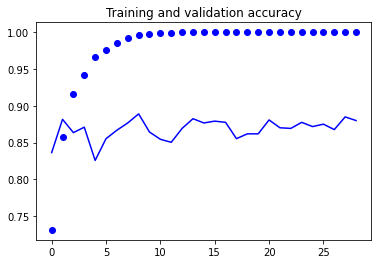

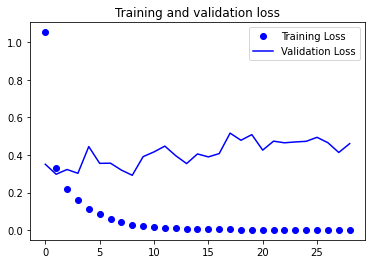

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

**Accuracy**

In [ ]:
acc = history.history['accuracy'][-1]
loss = history.history['loss'][-1]
print('Training Accuracy:',acc);
print('Training loss:',loss)

Training Accuracy: 1.0
Training loss: 0.0012187204556539655


**Loading the weights of the saved model for prediction**

In [ ]:
model.load_weights('/content/drive/MyDrive/CovidCV/inception_v3.hdf5')
preds_ft = model.predict(testgen)
pred_classes_ft = np.argmax(preds_ft, axis=1)

In [ ]:
true_classes = testgen.classes
print(true_classes)

[0 0 0 ... 1 1 1]


In [ ]:
from sklearn.metrics import accuracy_score

acc_ft = accuracy_score(true_classes, pred_classes_ft)
print("Test Accuracy: {:.2f}%".format(acc_ft * 100))

Test Accuracy: 95.30%


**Evaluation metrics**

In [ ]:
# precision tp / (tp + fp)
precision = precision_score(true_classes, pred_classes_ft)
print("Precision: {:.2f}%".format(precision))

# recall: tp / (tp + fn)
recall = recall_score(true_classes, pred_classes_ft)
print("Recall: {:.2f}%".format(recall))

# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(true_classes, pred_classes_ft)
print("F1 score: {:.2f}%".format(f1))

Precision: 0.95%
Recall: 0.95%
F1 score: 0.95%


In [ ]:
# confusion matrix
matrix = confusion_matrix(true_classes, pred_classes_ft)
print(matrix)

[[952  48]
 [ 46 954]]


**Test a sample image**

In [ ]:
from keras.preprocessing import image

img = image.load_img("/content/drive/MyDrive/CovidCV/test/covid/25847 (19).jpg",target_size=(150,150))
img = np.asarray(img).astype("float32")
img = np.expand_dims(img, axis=0)


output = model.predict(img)
if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")

Image is predicted as normal


## **EXPLAINABLE AI**

###**IMPLEMENTATION OF LIME**

In [ ]:
!pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Testing a covid sample image**

In [ ]:
img = testgen[10][10]
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output)

if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")

[[0.6959787  0.14022277]]
Image is predicted as covid


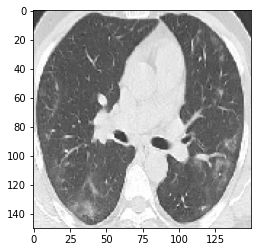

In [ ]:
plt.imshow(testgen[10][10])

**Calculating superpixels**

In [ ]:
Xi = img[0].astype("double")
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

21

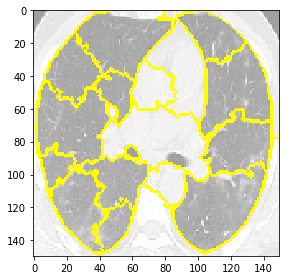

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0])

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

**Visualizing perturbed images**

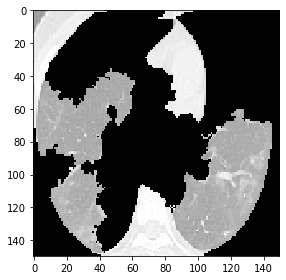

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[0],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

**Calculating distances using cosine metric**

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

**Mapping distance values to weights**

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
class_to_explain = 0
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([-0.02068197, -0.02155302,  0.19432565,  0.02526174,  0.05243429,
        0.01380211, -0.00180576, -0.02634379, -0.01966802,  0.01423184,
       -0.0267803 ,  0.0605089 , -0.06436049, -0.04850164, -0.00467704,
        0.00037314,  0.00196511, -0.01502145,  0.01322778,  0.02803076,
        0.05199616])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([20,  4, 11,  2])

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 149.5, 149.5, -0.5)

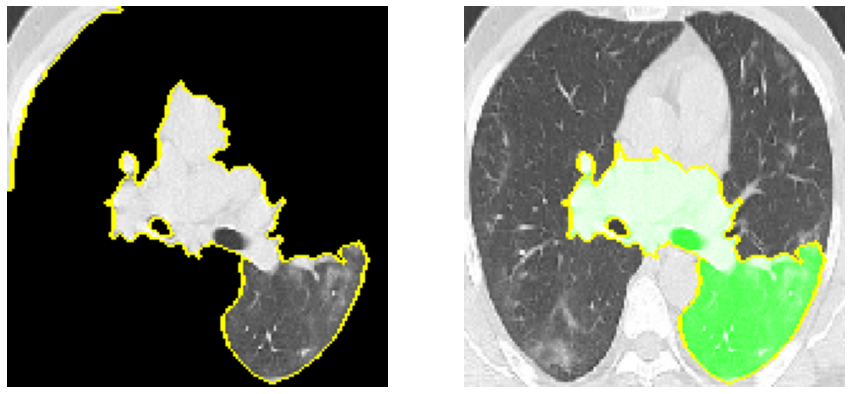

In [ ]:
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
from lime import lime_image

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi, model.predict)
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=4, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=2, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

**Testing a normal sample image**

In [ ]:
img = testgen[60][5]
img = np.expand_dims(img, axis=0)
output = model.predict(img)
print(output)

if output[0][0] > output[0][1]:
    print("Image is predicted as covid")
else:
    print("Image is predicted as normal")


[[0.01596198 0.8431945 ]]
Image is predicted as normal


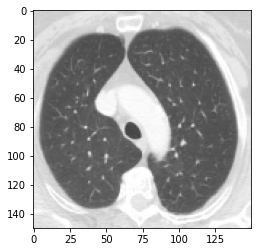

In [ ]:
plt.imshow(testgen[60][5])

**Calculating superpixels**

In [ ]:
Xi = img[0].astype("double")
superpixels = skimage.segmentation.quickshift(Xi, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

17

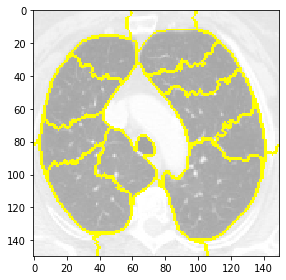

In [ ]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(Xi/2+0.5, superpixels))

In [ ]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0])

In [ ]:
def perturb_image(img,perturbation,segments):
  active_pixels = np.where(perturbation == 1)[0]
  mask = np.zeros(segments.shape)
  for active in active_pixels:
      mask[segments == active] = 1 
  perturbed_image = copy.deepcopy(img)
  perturbed_image = perturbed_image*mask[:,:,np.newaxis]
  return perturbed_image

**Visualizing perturbed images**

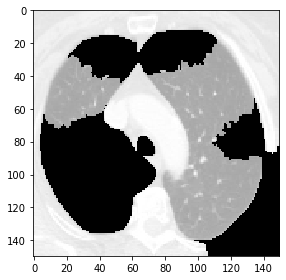

In [ ]:
skimage.io.imshow(perturb_image(Xi/2+0.5,perturbations[3],superpixels))

In [ ]:
predictions = []
for pert in perturbations:
  perturbed_img = perturb_image(Xi,pert,superpixels)
  pred = model.predict(perturbed_img[np.newaxis,:,:,:])
  predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

(150, 1, 2)

**Calculating distances using cosine metric**

In [ ]:
original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
distances.shape

(150,)

**Mapping distance values to weights**

In [ ]:
kernel_width = 0.25
weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
weights.shape

(150,)

In [ ]:
class_to_explain = 1
simpler_model = LinearRegression()
simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
coeff = simpler_model.coef_[0]
coeff

array([ 0.05571192, -0.01485152, -0.07938389, -0.02192503, -0.00739056,
        0.10985532, -0.05122936, -0.12120939, -0.0145336 ,  0.02159432,
        0.06727063, -0.03821081,  0.05084909, -0.00542045, -0.06420601,
        0.0285295 , -0.01417923])

In [ ]:
num_top_features = 4
top_features = np.argsort(coeff)[-num_top_features:] 
top_features

array([12,  0, 10,  5])

  0%|          | 0/1000 [00:00<?, ?it/s]

(-0.5, 149.5, 149.5, -0.5)

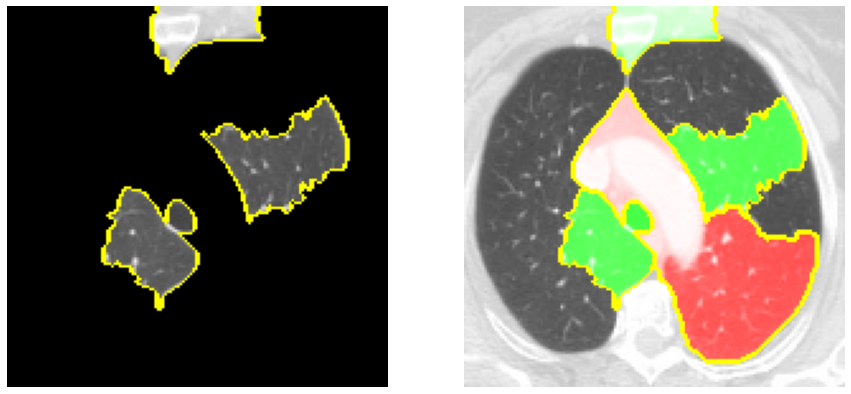

In [ ]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

explainer = lime_image.LimeImageExplainer()
explanation = explainer.explain_instance(Xi, model.predict)
temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=3, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

###**IMPLEMENTATION OF GRADCAM**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

def get_img_array(img_path, size):
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [ ]:
def save_and_display_gradcam(img, heatmap, cam_path="/content/drive/MyDrive/CovidCV/GradCAM result/cam.jpg", alpha=0.8):
    img = np.uint8(255 * img)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)
    superimposed_img.save(cam_path)
    display(Image(cam_path))
    return superimposed_img

**Testing a Covid sample Image**

(250, 250, 3)


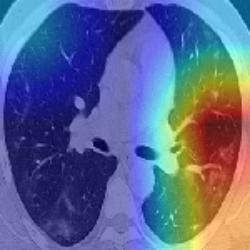

In [ ]:
img = testgen[10][22]
img = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img, model, 'mixed10')
heatmap = cv2.resize(heatmap, (150, 150))
img = testgen[10][10]
img = cv2.resize(img, (250,250))
superimposed_img = save_and_display_gradcam(img, heatmap)

**Testing a normal sample Image**

(250, 250, 3)


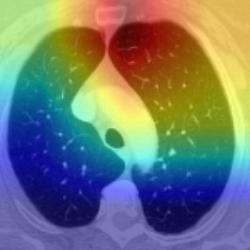

In [ ]:
img = testgen[12][7]
img = np.expand_dims(img, axis=0)
heatmap = make_gradcam_heatmap(img, model, 'mixed10')
heatmap = cv2.resize(heatmap, (150, 150))
img = testgen[60][5]
img = cv2.resize(img, (250,250))
print(img.shape)
superimposed_img = save_and_display_gradcam(img, heatmap)